### Getting started

In [1]:
import warnings

warnings.filterwarnings("ignore", message="Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.")

import numpy as np
import pandas as pd
import copy
import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict
###
# Multiprocessing
import multiprocessing.pool as mpp
from multiprocessing.pool import ThreadPool as Pool

# from https://stackoverflow.com/questions/57354700/starmap-combined-with-tqdm
# Author: Darkonaut (08/05/2019)

def istarmap(self, func, iterable, chunksize=1):
    """starmap-version of imap
    """
    self._check_running()
    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)

mpp.Pool.istarmap = istarmap

In [2]:
import matplotlib

matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

### Load data

- Here, we test and benchmark spatial genome alignment on __fine chromatin tracing (5 kb)__ of the __Sox2 locus__ in __mouse embryonic stem cells (mESC)__, imaged using a __different protocol__ (sequential multiplexed DNA-FISH) ([Huang _et al., Nat. Gen._ ,__53__,1064-1074 (2021)](https://www.nature.com/articles/s41588-021-00863-6?proof=tNature). 
<br></br>
    - This dataset describes a unique __insulator reporter system__!
    - It traces chromatin around mouse chromosome `chr3:34601078-34811078` of the _Sox2_ locus.
    - This spans a known __promoter__ and __enhancer__ associating within a domain
        - This promoter-enhancer contact is disrupted if tandem CTCF binding sites are inserted __between__ the promoter and enhancer.
        - ___This dataset below___ has tandem CTCF binding sites __downstream__ of the enhancer, and it was reported this did not disrupt promoter-enhancer contact.
        
***
##### Note on indexing
- The cell line in study is an F123 hybrid cell line with (_Mus musculus castaneous_ x S129/SvJae) background.
    - The __`allele='CAST'`__ allele has a __7.5 kb tandem CTCF binding site insert__ that corresponds to the 38th bin (0 indexed) imaged. 
        - While the sequential order of this insert is 38th bin (0 indexed), it is imaged as `hyb=25`. 
        - `hyb=24` and `hyb=26` are in fact separated by __5 kb__. 
        - `hyb=37` and `hyb=39` are separated by __10 kb__ on 129; `hyb=37` and `hyb=39` are sparated by __17.5 kb__ on `allele='CAST'`.
    <br></br>
    - The __`allele='129'`__ allele lacks this insert, serving as a control. 

***
##### Note on candidate spots
- These candidate spots were called using the procedure cited above, in a bid to benchmark the spatial genome aligner against an existing chromatin tracing algorithm.
    - First, a __chromosome center__ is found. __Two centers__ are sought within each cell: one for `allele='CAST'`, one for `allele='129'`.
        - Around each chromosome center (local), candidate spots are called for every hybridization round. 
            - This is different from the seqFISH+ dataset, where candidate spots discovered in the __entire nucleus__ (global) were reported.

In [3]:
# load data in
DNA_pts = pd.read_csv('../data/mesc_sox2/D41_candidates_RNA.csv')

# add dummy localization error
DNA_pts['sig_z'] = 1.
DNA_pts['sig_y'] = 1.
DNA_pts['sig_x'] = 1.

# rename columns
DNA_pts.rename(columns = {'z':'z_hat',
                          'y':'y_hat',
                          'x':'x_hat',
                          'cellid':'cell',
                          'round':'hyb'}, inplace=True)

# 0-index 'hyb'
DNA_pts['hyb'] = DNA_pts['hyb'] -  1

# convert nm measurements to pixels
DNA_pts['z_hat'] /= 200
DNA_pts['y_hat'] /= 109
DNA_pts['x_hat'] /= 109

# make everything positive
DNA_pts['z_hat'] += np.min(DNA_pts['z_hat'])
DNA_pts['y_hat'] += np.min(DNA_pts['y_hat'])
DNA_pts['x_hat'] += np.min(DNA_pts['x_hat'])

# select based on threshold
DNA_pts = DNA_pts[DNA_pts['score'] >= -4]

# label rows for later retrieval
DNA_pts['row_num'] = DNA_pts.index

# concatenate RNA burst data into one column
DNA_pts['RNA'] = [tuple(DNA_pts.iloc[idx, [7, 11, 12, 13, 14]]) for idx in range(DNA_pts.shape[0])] 
DNA_pts.rename(columns={'cell_id':'cell'}, inplace = True)

# remove insert
DNA_pts = DNA_pts[DNA_pts['hyb'] != 25]
DNA_pts.loc[DNA_pts['hyb']>=26, ['hyb']] -=1

# remove unassigned alleles
DNA_pts = DNA_pts[DNA_pts['allele'] != "Dropped"]

# filter by 129
DNA_pts = DNA_pts[DNA_pts['allele'] == "129"]

- Align!

In [4]:
from jie import aligner

def find_chr_pts(cell_pts):
    
    # params for benchmarking
    gene_dist = [5000*i for i in range(38)] + [5000 + 5000*i for i in range(38, 41)]
    nm_per_bp = .068
    bin_size = 5000
    stretch_factor = 1.1
    num_skip = 8
    total_num_skip_frac = 1
    init_skip_frac = 8/41
    
    # align
    mat, path, _ = aligner.find_chr(cell_pts_input = cell_pts, 
                                  gene_dist = gene_dist,
                                  bin_size = bin_size,
                                  nm_per_bp = nm_per_bp,
                                  stretch_factor = stretch_factor,
                                  num_skip = num_skip,
                                  total_num_skip_frac = total_num_skip_frac,
                                  init_skip_frac = init_skip_frac,
                                  norm_skip_penalty = True)
    
    return cell_pts.iloc[[elem for elem in path]]

if __name__ == '__main__':
    
    sel_chr_pts = []

    # group cells by chromosome center a.k.a. chr_num
    groups = DNA_pts.groupby('chr_num')
    
    # keep locations with substantial candidates
    for idx, (name, group) in enumerate(groups):
        if (len(np.unique(group.hyb)) >= 35) & (group.shape[0] >= 100):
        # save df
            sel_chr_pts.append(group)
            
    with Pool(1) as p:
        res = list(tqdm.tqdm(p.istarmap(find_chr_pts, zip(sel_chr_pts)), total = len(sel_chr_pts)))
        


  0%|                                                                                         | 0/366 [00:00<?, ?it/s]/home/b2jia/projects/jie/jie/aligner.py:564: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  pts_clr_next = cell_pts.loc[cell_pts['hyb'].between(i, i+num_skip, inclusive = False)]
  0%|▏                                                                                | 1/366 [00:00<01:10,  5.15it/s]/home/b2jia/projects/jie/jie/aligner.py:564: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  pts_clr_next = cell_pts.loc[cell_pts['hyb'].between(i, i+num_skip, inclusive = False)]
100%|███████████████████████████████████████████████████████████████████████████████| 366/366 [00:54<00:00,  6.69it/s]


##### Calculate distance and contact matrices

In [5]:
from jie import plot

# calculate EM spot selected distance matrix
chr_id = [df.chr_num.iloc[0] for df in res]
em_chosen_pts = DNA_pts[(DNA_pts['keep'] == True) & (DNA_pts['chr_num'].isin(chr_id))]
em_dflist = [df for _, df in em_chosen_pts.groupby('chr_num')]
em_distmat = plot.calc_med_dist_mat(em_dflist, 41)

# calculate spatial genome alignment distance matrix
jie_distmat = plot.calc_med_dist_mat(res, 41)

# grab hi-c
hic_mat = np.load('../data/npy/hic_sox2/CTCFx4-rep1-Ballele-noinsert.npy')

##### Plot

/tmp/ipykernel_4152774/435651325.py:25: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar1 = plt.colorbar(im1, cax=cax1, cmap = 'seismic_r')
/tmp/ipykernel_4152774/435651325.py:31: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar2 = plt.colorbar(im2, cax=cax2, cmap = 'seismic_r', label = 'Distance (nm)')
/tmp/ipykernel_4152774/435651325.py:37: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar3 = plt.colorbar(im3, cax=cax3, cmap = 'Reds', label = 'Counts')


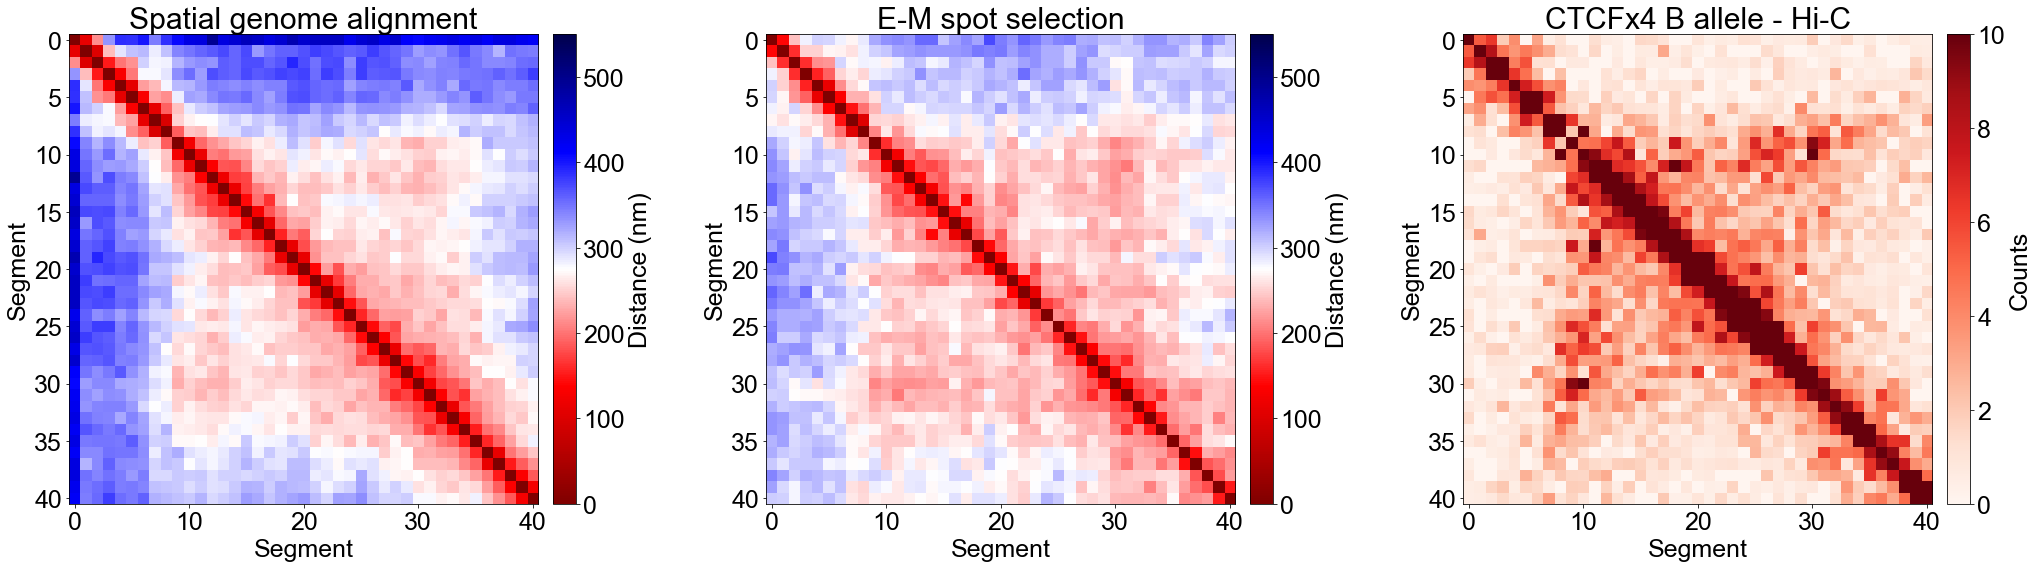

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize = (29, 8))
im1 = axs[0].imshow(100*jie_distmat, cmap = 'seismic_r', vmax = 550)
im2 = axs[1].imshow(100*em_distmat, cmap = 'seismic_r', vmax = 550)
im3 = axs[2].imshow(hic_mat, cmap = "Reds", vmax = 10)

axs[0].tick_params(axis='both', which='major', labelsize=25)
axs[1].tick_params(axis='both', which='major', labelsize=25)
axs[2].tick_params(axis='both', which='major', labelsize=25)

axs[0].set_title("Spatial genome alignment", fontsize = 30)
axs[1].set_title("E-M spot selection", fontsize = 30)
axs[2].set_title("CTCFx4 B allele - Hi-C", fontsize = 30)

axs[0].set_xlabel("Segment", fontsize = 25)
axs[0].set_ylabel("Segment", fontsize = 25)
axs[1].set_xlabel("Segment", fontsize = 25)
axs[1].set_ylabel("Segment", fontsize = 25)
axs[2].set_xlabel("Segment", fontsize = 25)
axs[2].set_ylabel("Segment", fontsize = 25)

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.2)
cbar1 = plt.colorbar(im1, cax=cax1, cmap = 'seismic_r')
cbar1.ax.tick_params(labelsize = 25)
cbar1.set_label(label="Distance (nm)", size = 25)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.2)
cbar2 = plt.colorbar(im2, cax=cax2, cmap = 'seismic_r', label = 'Distance (nm)')
cbar2.ax.tick_params(labelsize = 25)
cbar2.set_label(label="Distance (nm)", size = 25)

divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.2)
cbar3 = plt.colorbar(im3, cax=cax3, cmap = 'Reds', label = 'Counts')
cbar3.ax.tick_params(labelsize = 25)
cbar3.set_label(label="Counts", size = 25)
plt.tight_layout()

/tmp/ipykernel_4152774/2609118377.py:7: RuntimeWarning: divide by zero encountered in log
  x = np.log(jie_distmat.flatten())
/tmp/ipykernel_4152774/2609118377.py:8: RuntimeWarning: divide by zero encountered in log
  y = np.log(hic_mat.flatten())
/tmp/ipykernel_4152774/2609118377.py:37: RuntimeWarning: divide by zero encountered in log
  x2 = np.log(em_distmat.flatten())
/tmp/ipykernel_4152774/2609118377.py:38: RuntimeWarning: divide by zero encountered in log
  y2 = np.log(hic_mat.flatten())
/tmp/ipykernel_4152774/2609118377.py:69: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar1 = plt.colorbar(im1, cax=cax1, cmap = 'plasma')
/tmp/ipykernel_4152774/2609118377.py:75: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two mi

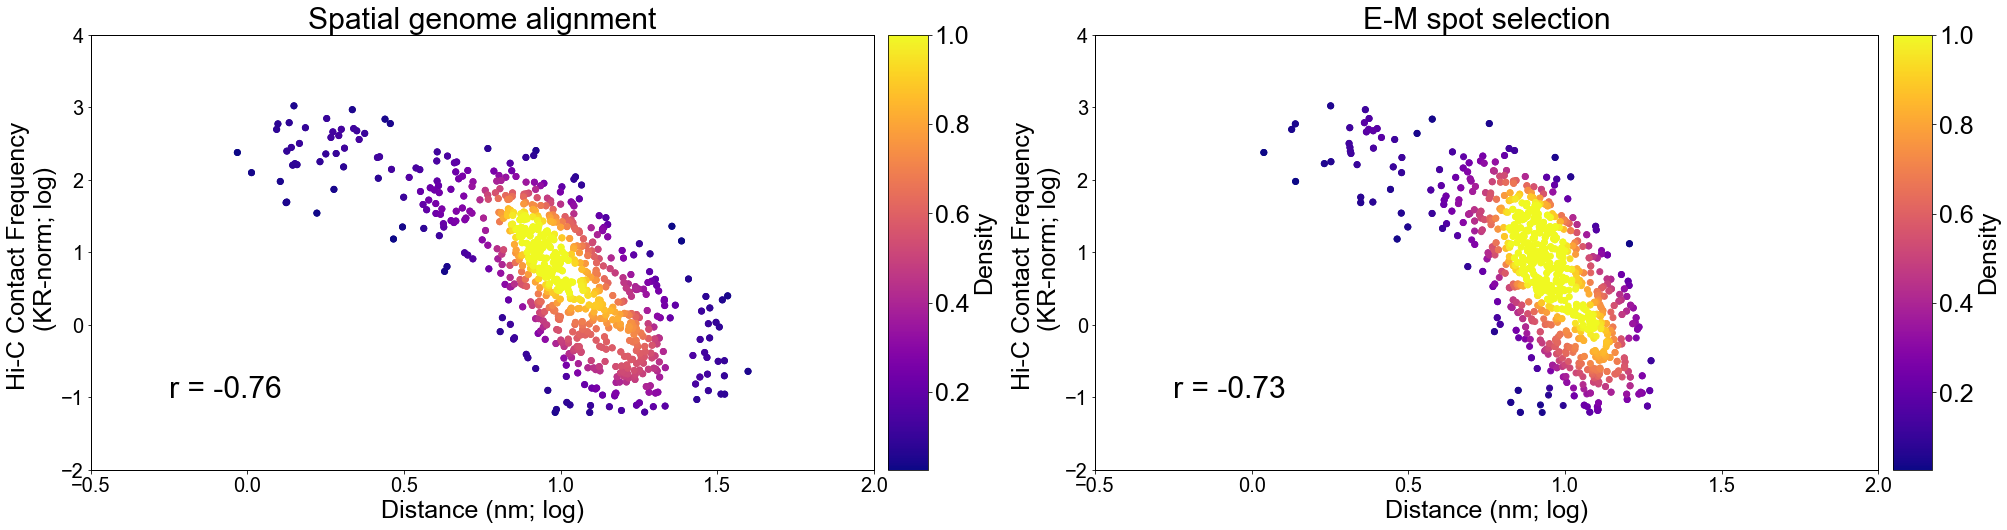

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr, gaussian_kde

fig, axs = plt.subplots(1, 2, figsize = (33, 8))

# KDE
x = np.log(jie_distmat.flatten())
y = np.log(hic_mat.flatten())
corr, _ = spearmanr(jie_distmat.flatten(), hic_mat.flatten(), nan_policy = 'omit')
drop_indeces = set(np.where(np.isinf(x))[0]).union(np.where(np.isinf(y))[0]) # remove inf
nan_indeces = set(np.where(np.isnan(x))[0]).union(np.where(np.isnan(y))[0]) # remove nans
drop_indeces = drop_indeces.union(nan_indeces)
x = [x[i] for i in range(len(x)) if i not in drop_indeces]
y = [y[i] for i in range(len(y)) if i not in drop_indeces]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
density = z.argsort()

im1 = axs[0].scatter([x[i] for i in density],
                                    [y[i] for i in density],
                                    c=[z[i] for i in density],
                                    cmap = 'plasma',
                                    alpha = 1,
                                    vmax = 1
                    )

axs[0].set_title("Spatial genome alignment", fontsize=30)
axs[0].patch.set_edgecolor('black')
axs[0].patch.set_linewidth('1')
axs[0].set_xlim(-0.5, 2)
axs[0].set_ylim(-2, 4)
axs[0].set_xlabel("Distance (nm; log)", fontsize = 25)
axs[0].set_ylabel("Hi-C Contact Frequency \n (KR-norm; log)", fontsize = 25)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].annotate('r = {0:.2g}'.format(corr), xy=(-0.25, -1), fontsize = 30)

x2 = np.log(em_distmat.flatten())
y2 = np.log(hic_mat.flatten())
corr2, _ = spearmanr(em_distmat.flatten(), hic_mat.flatten(), nan_policy = 'omit')
drop_indeces = set(np.where(np.isinf(x2))[0]).union(np.where(np.isinf(y2))[0]) # remove inf
nan_indeces = set(np.where(np.isnan(x2))[0]).union(np.where(np.isnan(y2))[0]) # remove nans
drop_indeces = drop_indeces.union(nan_indeces)
x2 = [x2[i] for i in range(len(x)) if i not in drop_indeces]
y2 = [y2[i] for i in range(len(y)) if i not in drop_indeces]
xy2 = np.vstack([x2, y2])
z2 = gaussian_kde(xy2)(xy2)
density = z2.argsort()

im2 = axs[1].scatter([x2[i] for i in density],
                                    [y2[i] for i in density],
                                    c=[z2[i] for i in density],
                                    cmap = 'plasma',
                                    alpha = 1,
                                    vmax = 1
                                   )

axs[1].set_title("E-M spot selection", fontsize=30)
axs[1].patch.set_edgecolor('black')
axs[1].patch.set_linewidth('1')
axs[1].set_xlim(-0.5, 2)
axs[1].set_ylim(-2, 4)
axs[1].set_xlabel("Distance (nm; log)", fontsize = 25)
axs[1].set_ylabel("Hi-C Contact Frequency \n (KR-norm; log)", fontsize = 25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].annotate('r = {0:.2g}'.format(corr2), xy=(-0.25, -1), fontsize = 30)

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.2)
cbar1 = plt.colorbar(im1, cax=cax1, cmap = 'plasma')
cbar1.ax.tick_params(labelsize = 25)
cbar1.set_label(label="Density", size = 25)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.2)
cbar2 = plt.colorbar(im2, cax=cax2, cmap = 'plasma')
cbar2.ax.tick_params(labelsize = 25)
cbar2.set_label(label="Density", size = 25)